[Sebastian Raschka](http://www.sebastianraschka.com)  
- Link to the containing GitHub Repository: [https://github.com/rasbt/pattern_classification](https://github.com/rasbt/pattern_classification)  
- Link to this IPython Notebook on GitHub: [linear_discriminant_analysis.ipynb](https://github.com/rasbt/pattern_classification/blob/master/dimensionality_reduction/projection/linear_discriminant_analysis.ipynb)

In [1]:
%load_ext watermark

In [2]:
%watermark -v -d -u -p pandas,scikit-learn,numpy,matplotlib 

last updated: 2016-02-23 

CPython 3.5.1
IPython 4.0.3

pandas 0.17.1
scikit-learn 0.17.1
numpy 1.10.4
matplotlib 1.5.0


<font size="1.5em">[More information](http://nbviewer.ipython.org/github/rasbt/python_reference/blob/master/ipython_magic/watermark.ipynb) about the `watermark` magic command extension.</font>

<hr>
I would be happy to hear your comments and suggestions. 
Please feel free to drop me a note via
[twitter](https://twitter.com/rasbt), [email](mailto:bluewoodtree@gmail.com), or [google+](https://plus.google.com/+SebastianRaschka).
<hr>

# Linear Discriminant Analysis bit by bit

<br>
<br>

### Sections

- [Introduction](#Introduction)
    - [Principal Component Analysis vs. Linear Discriminant Analysis](#Principal-Component-Analysis-vs.-Linear-Discriminant-Analysis)
    - [What is a "good" feature subspace?](#What-is-a-"good"-feature-subspace?)
    - [Summarizing the LDA approach in 5 steps](#Summarizing-the-LDA-approach-in-6-steps)
- [Preparing the sample data set](#Preparing-the-sample-data-set)
    - [About the Iris dataset](#About-the-Iris-dataset)
    - [Reading in the dataset](#Reading-in-the-dataset)
    - [Histograms and feature selection](#Histograms-and-feature-selection)
    - [Normality assumptions](#normality-assumptions)
- [LDA in 5 steps](#LDA-in-5-steps)
    - [Step 1: Computing the d-dimensional mean vectors](#Step-1:-Computing-the-d-dimensional-mean-vectors)
    - [Step 2: Computing the Scatter Matrices](#Step-2:-Computing-the-Scatter-Matrices)
    - [Step 3: Solving the generalized eigenvalue problem for the matrix $S_{W}^{-1}S_B$](#Step-3:-Solving-the-generalized-eigenvalue-problem-for-the-matrix-$S_{W}^{-1}S_B$)
    - [Step 4: Selecting linear discriminants for the new feature subspace](#Step-4:-Selecting-linear-discriminants-for-the-new-feature-subspace)
    - [Step 5: Transforming the samples onto the new subspace](#Step-5:-Transforming-the-samples-onto-the-new-subspace)
- [A comparison of PCA and LDA](#A-comparison-of-PCA-and-LDA)
- [LDA via scikit-learn](#LDA-via-scikit-learn)
- [A Note About Standardization](#A-Note-About-Standardization)

<br>
<br>

# Introduction

[[back to top](#Sections)]

Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique in the pre-processing step for pattern-classification and machine learning applications. 
The goal is to project a dataset onto a lower-dimensional space with good class-separability in order avoid overfitting ("curse of dimensionality") and also reduce computational costs.

Ronald A. Fisher formulated the *Linear Discriminant* in 1936 ([The Use of Multiple  Measurements in Taxonomic Problems](http://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x/abstract)), and it also has some practical uses as classifier. The original Linear discriminant was described for a 2-class problem, and it was then later generalized as "multi-class Linear Discriminant Analysis" or "Multiple Discriminant Analysis" by C. R. Rao in 1948 ([The utilization of multiple measurements in problems of biological classification](http://www.jstor.org/stable/2983775))


**The general LDA approach is very similar to a Principal Component Analysis (for more information about the PCA, see the previous article [Implementing a Principal Component Analysis (PCA) in Python step by step](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html)), but in addition to finding the component axes that maximize the variance of our data (PCA), we are additionally interested in the axes that maximize the separation between multiple classes (LDA).**

So, in a nutshell, often the goal of an LDA is to project a feature space (a dataset n-dimensional samples) onto a smaller subspace $k$ (where $k \leq n-1$) while maintaining the class-discriminatory information.   
In general, dimensionality reduction does not only help reducing computational costs for a given classification task, but it can also be helpful to avoid overfitting by minimizing the error in parameter estimation ("curse of dimensionality").

<br>
<br>

## Principal Component Analysis vs. Linear Discriminant Analysis

[[back to top](#Sections)]

Both Linear Discriminant Analysis (LDA) and Principal Component Analysis (PCA) are linear transformation techniques that are commonly used for dimensionality reduction. PCA can be described as an "unsupervised" algorithm, since it "ignores" class labels and its goal is to find the directions (the so-called principal components) that maximize the variance in a dataset.
In contrast to PCA, LDA is "supervised" and computes the directions ("linear discriminants") that  will represent the axes that that maximize the separation between multiple classes.

Although it might sound intuitive that LDA is superior to PCA for a multi-class classification task where the class labels are known, this might not always the case.  
For example, comparisons between classification accuracies for image recognition after using PCA or LDA show that PCA tends to outperform LDA if the number of samples per class is relatively small ([PCA vs. LDA](http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=908974), A.M. Martinez et al., 2001).
In practice, it is also not uncommon to use both LDA and PCA in combination: E.g., PCA for dimensionality reduction followed by an LDA.
<br>
<br>



![](../../Images/lda_1.png)


<br>
<br>

## What is a "good" feature subspace?

[[back to top](#Sections)]

Let's assume that our goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $(k)$-dimensional subspace (where $k\;<\;d$). 
So, how do we know what size we should choose for $k$ ($k$ = the number of dimensions of the new feature subspace), and how do we know if we have a feature space that represents our data "well"?  

Later, we will compute eigenvectors (the components) from our data set and collect them in a so-called scatter-matrices (i.e., the in-between-class scatter matrix and within-class scatter matrix).  
Each of these eigenvectors is associated with an eigenvalue, which tells us about the "length" or "magnitude" of the eigenvectors. 

If we would observe that all eigenvalues have a similar magnitude, then this may be a good indicator that our data is already projected on a "good" feature space.  

And in the other scenario, if some of the eigenvalues are much much larger than others, we might be interested in keeping only those eigenvectors with the highest eigenvalues, since they contain more information about our data distribution. Vice versa, eigenvalues that are close to 0 are less informative and we might consider dropping those for constructing the new feature subspace.

<br>
<br>

## Summarizing the LDA approach in 5 steps

[[back to top](#Sections)]

Listed below are the 5 general steps for performing a linear discriminant analysis; we will explore them in more detail in the following sections.

1. Compute the $d$-dimensional mean vectors for the different classes from the dataset.
2. Compute the scatter matrices (in-between-class and within-class scatter matrix).
3. Compute the eigenvectors ($\pmb e_1, \; \pmb e_2, \; ..., \; \pmb e_d$) and corresponding eigenvalues ($\pmb \lambda_1, \; \pmb \lambda_2, \; ..., \; \pmb \lambda_d$) for the scatter matrices.
4. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $k \times d$ dimensional matrix $\pmb W\;$ (where every column represents an eigenvector).
5. Use this $k \times d$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $\pmb Y = \pmb X \times \pmb W$ (where $\pmb X$ is a $n \times d$-dimensional matrix representing the $n$ samples, and $\pmb y$ are the transformed $n \times k$-dimensional samples in the new subspace).

<a name="sample_data"></a>
<br>
<br>

# Preparing the sample data set

[[back to top](#Sections)]

<a name="sample_data"></a>
<br>
<br>

## About the Iris dataset

[[back to top](#Sections)]

For the following tutorial, we will be working with the famous "Iris" dataset that has been deposited on the UCI machine learning repository  
(https://archive.ics.uci.edu/ml/datasets/Iris).



<font size="1">
**Reference:**
Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science.</font>

The iris dataset contains measurements for 150 iris flowers from  three different species.

The three classes in the Iris dataset:

1. Iris-setosa (n=50)
2. Iris-versicolor (n=50)
3. Iris-virginica (n=50)

The four features of the Iris dataset:

1.	sepal length in cm
2.	sepal width in cm
3.	petal length in cm
4.	petal width in cm


![](../../Images/iris_petal_sepal.png)

In [3]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm', 
                  'sepal width in cm', 
                  'petal length in cm', 
                  'petal width in cm', ))}

<a name="sample_data"></a>
<br>
<br>

## Reading in the dataset

[[back to top](#Sections)]

In [4]:
import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',', 
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


$\pmb X = \begin{bmatrix} x_{1_{\text{sepal length}}} & x_{1_{\text{sepal width}}} & x_{1_{\text{petal length}}} & x_{1_{\text{petal width}}}\\ 
x_{2_{\text{sepal length}}} & x_{2_{\text{sepal width}}} & x_{2_{\text{petal length}}} & x_{2_{\text{petal width}}}\\ 
...  \\
x_{150_{\text{sepal length}}} & x_{150_{\text{sepal width}}} & x_{150_{\text{petal length}}} & x_{150_{\text{petal width}}}\\ 
\end{bmatrix}, \;\;
\pmb y = \begin{bmatrix} \omega_{\text{setosa}}\\ 
\omega_{\text{setosa}}\\ 
...  \\
\omega_{\text{virginica}}\end{bmatrix}$

<a name="sample_data"></a>
<br>
<br>

Since it is more convenient to work with numerical values, we will use the `LabelEncode` from the `scikit-learn` library to convert the class labels into numbers: `1, 2, and 3`.

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df[[0,1,2,3]].values 
y = df['class label'].values 

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

$\pmb y = \begin{bmatrix}{\text{setosa}}\\ 
{\text{setosa}}\\ 
...  \\
{\text{virginica}}\end{bmatrix} \quad \Rightarrow
\begin{bmatrix} {\text{1}}\\ 
{\text{1}}\\ 
...  \\
{\text{3}}\end{bmatrix}$



<a name="sample_data"></a>
<br>
<br>

## Histograms and feature selection

[[back to top](#Sections)]

Just to get a rough idea how the samples of our three classes $\omega_1$, $\omega_2$ and $\omega_3$ are distributed, let us visualize the distributions of the four different features in 1-dimensional histograms.

In [8]:
%matplotlib inline

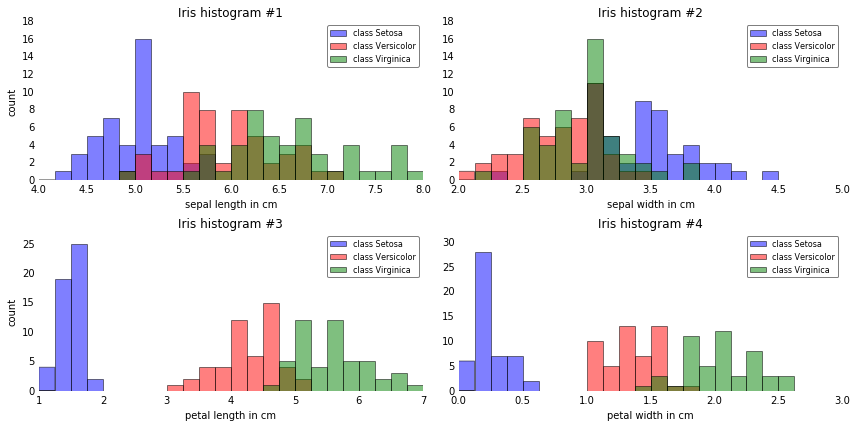

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  
    
    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)
    
    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col, 
                   label='class %s' %label_dict[lab], 
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()
    
    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))
    
    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["left"].set_visible(False)    
 
axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')
    
fig.tight_layout()       
        
plt.show()

From just looking at these simple graphical representations of the features, we can already tell that the petal lengths and widths are likely better suited as potential features two separate between the three flower classes. In practice, instead of reducing the dimensionality via a projection (here: LDA), a good alternative would be a feature selection technique. For low-dimensional datasets like Iris, a glance at those histograms would already be very informative. Another simple, but very useful technique would be to use feature selection algorithms, which I have described in more detail in another article: [Feature Selection Algorithms in Python](http://sebastianraschka.com/Articles/2014_sequential_sel_algos.html)

<a name="sample_data"></a>
<br>
<br>

## Normality assumptions

[[back to top](#Sections)]

It should be mentioned that LDA assumes normal distributed data, features that are statistically independent, and identical covariance matrices for every class. However, this only applies for LDA as classifier and LDA for dimensionality reduction can also work reasonably well if those assumptions are violated. And even for classification tasks LDA seems can be quite robust to the distribution of the data: 

> "linear discriminant analysis frequently achieves good performances in
> the tasks of face and object recognition, even though the assumptions
> of common covariance matrix among groups and normality are often
> violated (Duda, et al., 2001)" (Tao Li, et al., 2006).

<br>

 

Tao Li, Shenghuo Zhu, and Mitsunori Ogihara. “[Using Discriminant Analysis for Multi-Class Classification: An Experimental Investigation](http://link.springer.com/article/10.1007%2Fs10115-006-0013-y).” Knowledge and Information Systems 10, no. 4 (2006): 453–72.)   

Duda, Richard O, Peter E Hart, and David G Stork. 2001. Pattern Classification. New York: Wiley.

<a name="sample_data"></a>
<br>
<br>

# LDA in 5 steps

[[back to top](#Sections)]

After we went through several preparation steps, our data is finally ready for the actual LDA. In practice, LDA for dimensionality reduction would be just another preprocessing step for a typical machine learning or pattern classification task.

<a name="sample_data"></a>
<br>
<br>

## Step 1: Computing the d-dimensional mean vectors

[[back to top](#Sections)]

In this first step, we will start off with a simple computation of the mean vectors $\pmb m_i$, $(i = 1,2,3)$ of the 3 different flower classes:
    
$\pmb m_i = \begin{bmatrix} 
\mu_{\omega_i (\text{sepal length)}}\\ 
\mu_{\omega_i (\text{sepal width})}\\ 
\mu_{\omega_i (\text{petal length)}}\\
\mu_{\omega_i (\text{petal width})}\\
\end{bmatrix} \; , \quad \text{with} \quad i = 1,2,3$

In [11]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [ 5.006  3.418  1.464  0.244]

Mean Vector class 2: [ 5.936  2.77   4.26   1.326]

Mean Vector class 3: [ 6.588  2.974  5.552  2.026]



<a name="sample_data"></a>
<br>
<br>

<a name="sc_matrix"></a>

##  Step 2: Computing the Scatter Matrices

[[back to top](#Sections)]

Now, we will compute the two *4x4*-dimensional matrices: The within-class and the between-class scatter matrix.

<br>
<br>

### 2.1 Within-class scatter matrix $S_W$

[[back to top](#Sections)]

The **within-class scatter** matrix $S_W$ is computed by the following equation:  

$S_W = \sum\limits_{i=1}^{c}  S_i$

where  
$S_i = \sum\limits_{\pmb x \in D_i}^n (\pmb x - \pmb m_i)\;(\pmb x - \pmb m_i)^T$  
(scatter matrix for every class) 

and $\pmb m_i$ is the mean vector    
$\pmb m_i = \frac{1}{n_i} \sum\limits_{\pmb x \in D_i}^n \; \pmb x_k$

In [12]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[ 38.9562  13.683   24.614    5.6556]
 [ 13.683   17.035    8.12     4.9132]
 [ 24.614    8.12    27.22     6.2536]
 [  5.6556   4.9132   6.2536   6.1756]]


<br>

### 2.1 b

Alternatively, we could also compute the class-covariance matrices by adding the scaling factor $\frac{1}{N-1}$ to the within-class scatter matrix, so that our equation becomes

$\Sigma_i = \frac{1}{N_{i}-1} \sum\limits_{\pmb x \in D_i}^n (\pmb x - \pmb m_i)\;(\pmb x - \pmb m_i)^T$.

and $S_W = \sum\limits_{i=1}^{c} (N_{i}-1) \Sigma_i$

where $N_{i}$ is the sample size of the respective class (here: 50), and in this particular case, we can drop the term ($N_{i}-1)$ 
since all classes have the same sample size.

However, the resulting eigenspaces will be identical (identical eigenvectors, only the eigenvalues are scaled differently by a constant factor).

<br>
<br>

### 2.2 Between-class scatter matrix $S_B$

[[back to top](#Sections)]

The **between-class scatter** matrix $S_B$ is computed by the following equation:  

$S_B =  \sum\limits_{i=1}^{c} N_{i} (\pmb m_i - \pmb m) (\pmb m_i - \pmb m)^T$

where  
 $\pmb m$ is the overall mean, and $\pmb m_{i}$ and $N_{i}$ are the sample mean and sizes of the respective classes.

In [13]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[  63.2121  -19.534   165.1647   71.3631]
 [ -19.534    10.9776  -56.0552  -22.4924]
 [ 165.1647  -56.0552  436.6437  186.9081]
 [  71.3631  -22.4924  186.9081   80.6041]]


<br>
<br>

## Step 3: Solving the generalized eigenvalue problem for the matrix $S_{W}^{-1}S_B$

[[back to top](#Sections)]

Next, we will solve the generalized eigenvalue problem for the matrix $S_{W}^{-1}S_B$ to obtain the linear discriminants.

In [14]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[ 0.179 ]
 [-0.3178]
 [-0.3658]
 [ 0.6011]]
Eigenvalue 3: -4.02e-17

Eigenvector 4: 
[[ 0.179 ]
 [-0.3178]
 [-0.3658]
 [ 0.6011]]
Eigenvalue 4: -4.02e-17


<br>
<br>

After this decomposition of our square matrix into eigenvectors and eigenvalues, let us briefly recapitulate how we can interpret those results. As we remember from our first linear algebra class in high school or college, both eigenvectors and eigenvalues are providing us with information about the distortion of a linear transformation: The eigenvectors are basically the direction of this distortion, and the eigenvalues are the scaling factor for the eigenvectors that describing the magnitude of the distortion.  

If we are performing the LDA for dimensionality reduction, the eigenvectors are important since they will form the new axes of our new feature subspace; the associated eigenvalues are of particular interest since they will tell us how "informative" the new "axes" are.  

Let us briefly double-check our calculation and talk more about the eigenvalues in the next section.

<br>
<br>

### Checking the eigenvector-eigenvalue calculation

[[back to top](#Sections)]



A quick check that the eigenvector-eigenvalue calculation is correct and satisfy the equation:

$\pmb A\pmb{v} =  \lambda\pmb{v}$  

<br>
where  
$\pmb A = S_{W}^{-1}S_B\\
\pmb{v} = \; \text{Eigenvector}\\
\lambda = \; \text{Eigenvalue}$

In [15]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1) 
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv), 
                                         eig_vals[i] * eigv, 
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


<br>
<br>

## Step 4: Selecting linear discriminants for the new feature subspace

[[back to top](#Sections)]

<br>
<br>

### 4.1. Sorting the eigenvectors by decreasing eigenvalues

[[back to top](#Sections)]



Remember from the introduction that we are not only interested in merely projecting the data into a subspace that improves the class separability, but also reduces the dimensionality of our feature space, (where the eigenvectors will form the axes of this new feature subspace). 

However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1.

So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.  
The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top $k$ eigenvectors.

In [16]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.2719577997
0.27756686384
5.71450476746e-15
5.71450476746e-15


<br>
<br>

If we take a look at the eigenvalues, we can already see that 2 eigenvalues are close to 0 and conclude that the eigenpairs are less informative than the other two. Let's express the "explained variance" as percentage:

In [17]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


<br>
<br>

The first eigenpair is by far the most informative one, and we won't loose much information if we would form a 1D-feature spaced based on this eigenpair.

<br>
<br>

### 4.2. Choosing *k* eigenvectors with the largest eigenvalues

[[back to top](#Sections)]

After sorting the eigenpairs by decreasing eigenvalues, it is now time to construct our $k \times d$-dimensional eigenvector matrix $\pmb W$ (here $4 \times 2$: based on the 2 most informative eigenpairs) and thereby reducing the initial 4-dimensional feature space into a 2-dimensional feature subspace.

In [18]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.2049 -0.009 ]
 [-0.3871 -0.589 ]
 [ 0.5465  0.2543]
 [ 0.7138 -0.767 ]]


<br>
<br>

# Step 5: Transforming the samples onto the new subspace

[[back to top](#Sections)]

In the last step, we use the $4 \times 2$-dimensional matrix $\pmb W$ that we just computed to transform our samples onto the new subspace via the equation   

$\pmb Y = \pmb X \times \pmb W $.

(where $\pmb X$ is a $n \times d$-dimensional matrix representing the $n$ samples, and $\pmb Y$ are the transformed $n \times k$-dimensional samples in the new subspace).

In [19]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 2x150 dimensional."

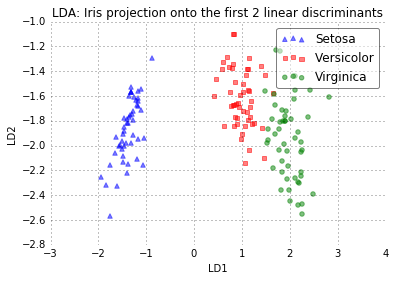

In [20]:
from matplotlib import pyplot as plt

def plot_step_lda():
    
    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')
    
    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["left"].set_visible(False)    
 
    plt.grid()
    plt.tight_layout
    plt.show()
    
plot_step_lda()

The scatter plot above represents our new feature subspace that we constructed via LDA. We can see that the first linear discriminant "LD1" separates the classes quite nicely. However, the second discriminant, "LD2", does not add much valuable information, which we've already concluded when we looked at the ranked eigenvalues is step 4.

<br>
<br>

# A comparison of PCA and LDA

[[back to top](#Sections)]

In order to compare the feature subspace that we obtained via the Linear Discriminant Analysis, we will use the `PCA` class from the `scikit-learn` machine-learning library. The documentation can be found here:  
[http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  

For our convenience, we can directly specify to how many components we want to retain in our input dataset via the `n_components` parameter. 

    n_components : int, None or string
    
    Number of components to keep. if n_components is not set all components are kept:
        n_components == min(n_samples, n_features)
        if n_components == ‘mle’, Minka’s MLE is used to guess the dimension if 0 < n_components < 1, 
        select the number of components such that the amount of variance that needs to be explained 
        is greater than the percentage specified by n_components

<br>
<br>

But before we skip to the results of the respective linear transformations, let us quickly recapitulate the purposes of PCA and LDA: PCA finds the axes with maximum variance for the whole data set where LDA tries to find the axes for best class seperability. In practice, often a LDA is done followed by a PCA for dimensionality reduction.

<br>
<br>


![](https://raw.githubusercontent.com/rasbt/pattern_classification/master/Images/lda_1.png)

<br>
<br>

In [22]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)
    
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["left"].set_visible(False)    
    
    plt.tight_layout
    plt.grid()
    
    plt.show()

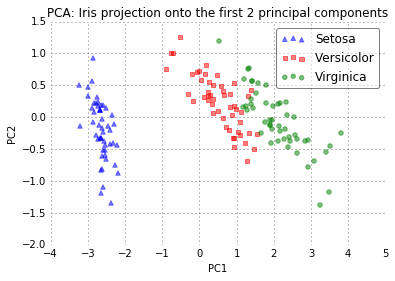

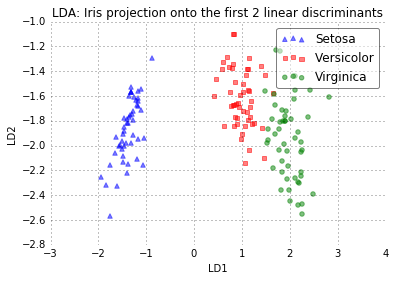

In [24]:
plot_pca()
plot_step_lda()

<br>
<br>

The two plots above nicely confirm what we have discussed before: Where the PCA accounts for the most variance in the whole dataset, the LDA gives us the axes that account for the most variance between the individual classes.

<br>
<br>

# LDA via scikit-learn

[[back to top](#Sections)]

Now, after we have seen how an Linear Discriminant Analysis works using a step-by-step approach, there is also a more convenient way to achive the same via the `LDA` class implemented in the [`scikit-learn`](http://scikit-learn.org/stable/) machine learning library.


In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

In [30]:
def plot_scikit_lda(X, title):
    
    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):
        
        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])
  
    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)
    
    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["left"].set_visible(False)    
 
    plt.grid()
    plt.tight_layout
    plt.show()

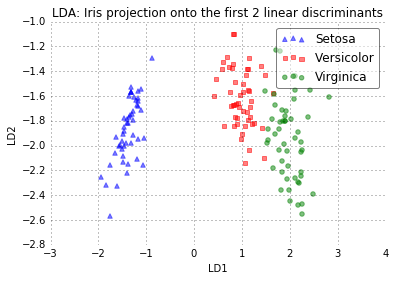

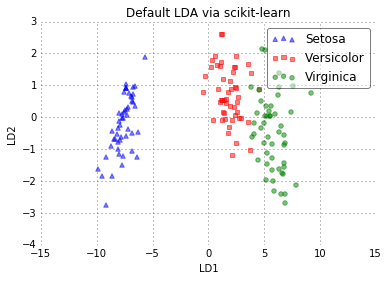

In [31]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')

<br>
<br>

# A Note About Standardization

[[back to top](#Sections)]

To follow up on a question that I received recently, I wanted to clarify that feature scaling such as [standardization] does **not** change the overall results of an LDA and thus may be optional. Yes, the scatter matrices will be different depending on whether the features were scaled or not. In addition, the eigenvectors will be different as well. However, the important part is that the eigenvalues will be exactly the same as well as the final projects -- the only difference you'll notice is the scaling of the component axes. This can be shown mathematically (I will insert the formulaes some time in future), and below is a practical, visual example for demonstration.

In [32]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df[4] = df[4].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


After loading the dataset, we are going to standardize the columns in `X`. Standardization implies mean centering and scaling to unit variance:

$$x_{std} = \frac{x - \mu_x}{\sigma_X}$$

After standardization, the columns will have zero mean ( $\mu_{x_{std}}=0$ ) and a standard deviation of 1 ($\sigma_{x_{std}}=1$).

In [33]:
y, X = df.iloc[:, 4].values, df.iloc[:, 0:4].values
X_cent = X - X.mean(axis=0) 
X_std = X_cent / X.std(axis=0)

Below, I simply copied the individual steps of an LDA, which we discussed previously, into Python functions for convenience.

In [34]:
import numpy as np

def comp_mean_vectors(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    mean_vectors = []
    for cl in class_labels:
        mean_vectors.append(np.mean(X[y==cl], axis=0))
    return mean_vectors
        
def scatter_within(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)
    S_W = np.zeros((n_features, n_features))
    for cl, mv in zip(class_labels, mean_vectors):
        class_sc_mat = np.zeros((n_features, n_features))                 
        for row in X[y == cl]:
            row, mv = row.reshape(n_features, 1), mv.reshape(n_features, 1) 
            class_sc_mat += (row-mv).dot((row-mv).T)
        S_W += class_sc_mat                           
    return S_W

def scatter_between(X, y):
    overall_mean = np.mean(X, axis=0)
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)    
    S_B = np.zeros((n_features, n_features))
    for i, mean_vec in enumerate(mean_vectors):  
        n = X[y==i+1,:].shape[0]
        mean_vec = mean_vec.reshape(n_features, 1) 
        overall_mean = overall_mean.reshape(n_features, 1) 
        S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    return S_B

def get_components(eig_vals, eig_vecs, n_comp=2):
    n_features = X.shape[1]
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    W = np.hstack([eig_pairs[i][1].reshape(4, 1) for i in range(0, n_comp)])
    return W

First, we are going to print the eigenvalues, eigenvectors, transformation matrix of the un-scaled data:

In [35]:
S_W, S_B = scatter_within(X, y), scatter_between(X, y)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
W = get_components(eig_vals, eig_vecs, n_comp=2)
print('EigVals: %s\n\nEigVecs: %s' % (eig_vals, eig_vecs))
print('\nW: %s' % W)

EigVals: [  2.0905e+01 +0.0000e+00j   1.4283e-01 +0.0000e+00j
  -2.8680e-16 +1.9364e-15j  -2.8680e-16 -1.9364e-15j]

EigVecs: [[ 0.2067+0.j      0.0018+0.j      0.4846-0.4436j  0.4846+0.4436j]
 [ 0.4159+0.j     -0.5626+0.j      0.0599+0.1958j  0.0599-0.1958j]
 [-0.5616+0.j      0.2232+0.j      0.1194+0.1929j  0.1194-0.1929j]
 [-0.6848+0.j     -0.7960+0.j     -0.6892+0.j     -0.6892-0.j    ]]

W: [[ 0.2067+0.j  0.0018+0.j]
 [ 0.4159+0.j -0.5626+0.j]
 [-0.5616+0.j  0.2232+0.j]
 [-0.6848+0.j -0.7960+0.j]]


/Users/sebastian/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:525: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


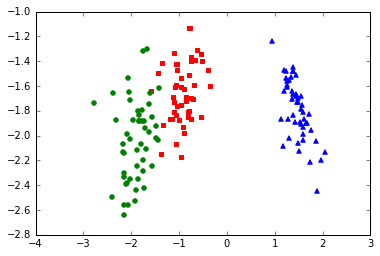

In [36]:
X_lda = X.dot(W)
for label,marker,color in zip(
        np.unique(y),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(X_lda[y==label, 0], X_lda[y==label, 1], 
                color=color, marker=marker)

Next, we are repeating this process for the standarized flower dataset:

In [37]:
S_W, S_B = scatter_within(X_std, y), scatter_between(X_std, y)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
W_std = get_components(eig_vals, eig_vecs, n_comp=2)
print('EigVals: %s\n\nEigVecs: %s' % (eig_vals, eig_vecs))
print('\nW: %s' % W_std)

EigVals: [  2.0905e+01   1.4283e-01  -6.7207e-16   1.1082e-15]

EigVecs: [[ 0.1492 -0.0019  0.8194 -0.3704]
 [ 0.1572  0.3193 -0.1382 -0.0884]
 [-0.8635 -0.5155 -0.5078 -0.5106]
 [-0.4554  0.7952 -0.2271  0.7709]]

W: [[ 0.1492 -0.0019]
 [ 0.1572  0.3193]
 [-0.8635 -0.5155]
 [-0.4554  0.7952]]


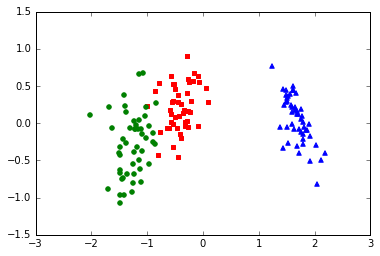

In [40]:
X_std_lda = X_std.dot(W_std)
X_std_lda[:, 1] = X_std_lda[:, 1] * (-1) # flip figure horizontally
for label,marker,color in zip(
        np.unique(y),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(X_std_lda[y==label, 0], X_std_lda[y==label, 1], 
                color=color, marker=marker)

As we can see, the eigenvalues are excactly the same whether we scaled our data or not (note that since $W$ has a rank of 2, the two lowest eigenvalues in this 4-dimensional dataset should effectively be 0). Furthermore, we see that the projections look identical except for the different scaling of the component axes and that it is mirrored in this case.